## Data Cleaning and Pre-Processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
datetime.datetime.strptime
import statsmodels.api as sm
import folium
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import data
df = pd.read_csv('strava.csv')

In [3]:
#1
df['timestamp'] = pd.to_datetime(df['timestamp'])

#2
df['Cadence'] = df['cadence'].where((df['cadence']!=0.0), df['Cadence'])

#3
dfc = df[['Air Power', 'Form Power', 'Ground Time','Leg Spring Stiffness', 'Power', 'Vertical Oscillation', 
          'enhanced_altitude','datafile', 'distance', 'heart_rate','position_lat','position_long','enhanced_speed','timestamp','Cadence']]

#4 
dfc['lat'] = dfc['position_lat']/10000000
dfc['lng'] = dfc['position_long']/10000000

#5
dfc['date'] = pd.to_datetime(dfc['timestamp']).dt.to_period('D')

#let's take a look at the data
dfc.head()


,Air Power,Form Power,Ground Time,Leg Spring Stiffness,Power,Vertical Oscillation,enhanced_altitude,datafile,distance,heart_rate,position_lat,position_long,enhanced_speed,timestamp,Cadence,lat,lng,date
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,activities/2675855419.fit.gz,0.00,68.0,NaN,NaN,0.000,2019-07-08 21:04:03,NaN,NaN,NaN,2019-07-08
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,activities/2675855419.fit.gz,0.00,68.0,NaN,NaN,0.000,2019-07-08 21:04:04,NaN,NaN,NaN,2019-07-08
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,activities/2675855419.fit.gz,1.32,71.0,NaN,NaN,1.316,2019-07-08 21:04:07,54.0,NaN,NaN,2019-07-08
3,NaN,NaN,NaN,NaN,NaN,NaN,249.4,activities/2675855419.fit.gz,12.19,77.0,504432050.0,-999063637.0,1.866,2019-07-08 21:04:14,77.0,50.443205,-99.906364,2019-07-08
4,NaN,NaN,NaN,NaN,NaN,NaN,259.6,activities/2675855419.fit.gz,14.08,80.0,504432492.0,-999064534.0,1.894,2019-07-08 21:04:15,77.0,50.443249,-99.906453,2019-07-08


## Basic Visual Analysis Techniques

### 1. Overview of Data: A Set of Histograms of Frequency

The frequency is useful to check how targeted the workouts were. Is the power scattered all over the chart? How intense was the workouts? How was the cadence during the workouts? I wanted to create a few histograms for the most interesting variables and see how the user's exercise was like in general, and see how I can explore the dataset further out from here. 

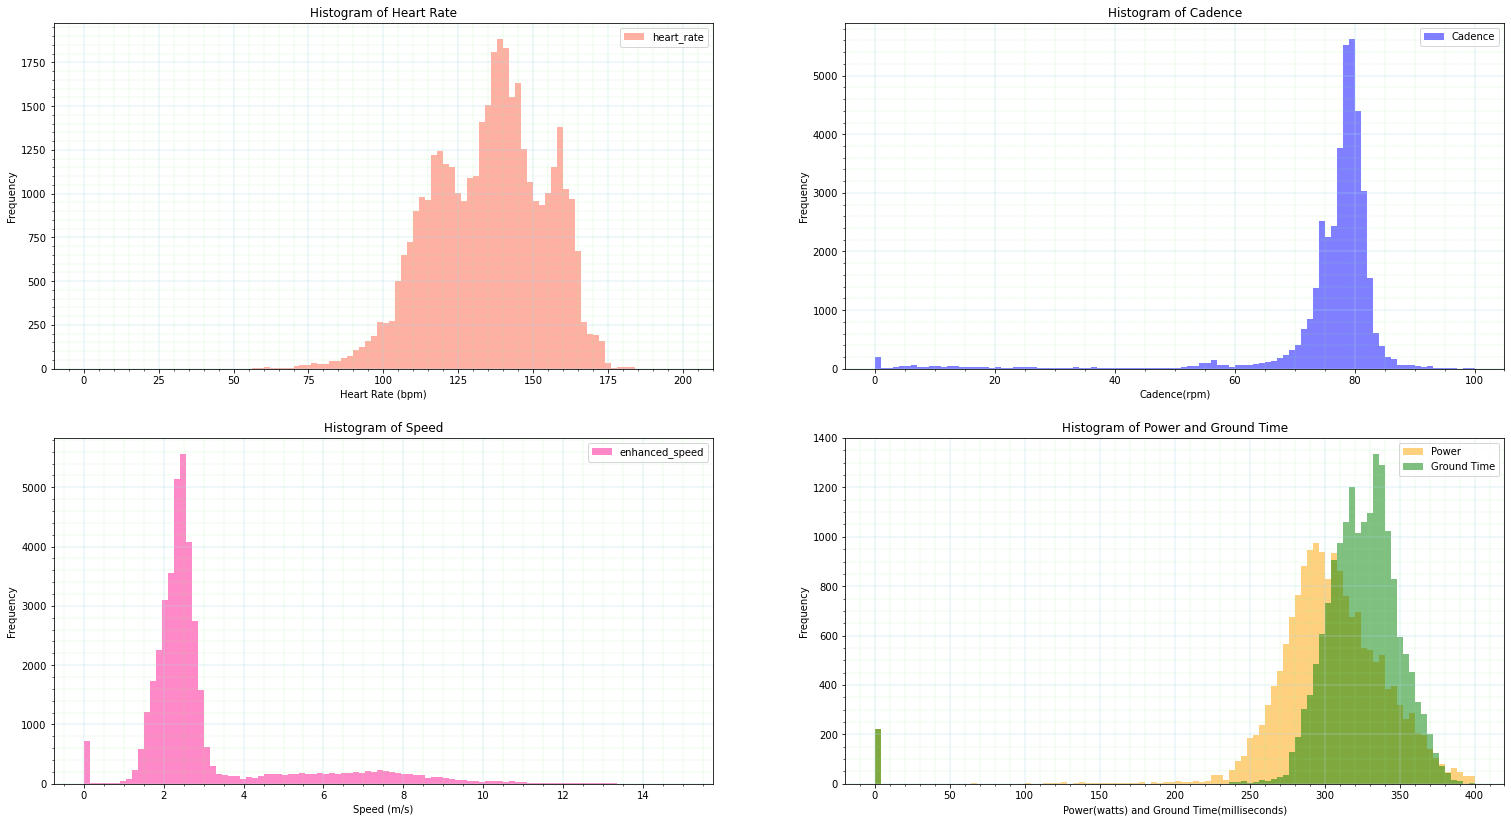

In [4]:
#create a set of 4 subplots 

fig,ax = plt.subplots(2,2,figsize=(26, 14))

def hist(col,rng,color,ax,title,xlabel):
    dfc[col].plot.hist(bins=100, alpha=0.5, range= rng, color = color,ax=ax) #pass in paremeters for each subplot
    ax.legend()
    ax.minorticks_on()
    ax.grid(which='major', linestyle='-', linewidth='0.4', color='lightblue') # adding grid in the background 
    ax.grid(which='minor', linestyle=':', linewidth='0.4', color='lightgreen')
    ax.title.set_text(title) #setting title for each subplot
    ax.set_xlabel(xlabel)
    return None

hist('heart_rate',(0, 200),'tomato',ax[0][0],'Histogram of Heart Rate','Heart Rate (bpm)')
hist('Cadence',(0, 100),'blue',ax[0][1],'Histogram of Cadence','Cadence(rpm)')
hist('enhanced_speed',(0, 15),'deeppink',ax[1][0],'Histogram of Speed','Speed (m/s)')
hist(['Power','Ground Time'],(0, 400),['orange','green'],ax[1][1],'Histogram of Power and Ground Time','Power(watts) and Ground Time(milliseconds)')



#### Insights: 
The story behind the above visualization:

1. Heart rate is mostly between 105 ~ 165, with a upper limit of ~180. A way of calculating maximum heart rate (the upper limit of what your cardiovascular system can handle during physical activity) is subtracting the age from 220. The user was 41 years old in 2019, so his maximum heart rate should be 179. The histogram of heart rate exactly shows this!  Vigorous exercise intensity can be defined as 70% to about 85% of the maximum heart rate, in this case - 125 to 152. It looks like most of the time the user was doing vigorous workouts! 

2. Cadence is highly concentrated around 80. What activity can it be? A 80 rpm is a reasonable spot for running, but it can be cycling as well. Recreational cyclists typically cycle at around 60 – 80 RPM, while advanced and elite cyclists pedal anywhere from 90 to 110 RPM(Green, 2022). Let's put the question aside for now as we will explore further later.

3. Speed: part of it is concentrating around 2.5 m/s, while other datapoints are scattered in a range of 3.5 to 11. It looks like there are two different activities, maybe running and cycling. 

4. Power ranges from ~240 to 400 and ground time ranges from ~280 to 370. 
a. A reasonable number for power of a recreational runner is about 3.6 watts/kg which converts to 316 for a 40 years old 88kg male(average weight of male adults in the North America). From the above histogram of power we can see the user's power metrc is mostly between 250 and 350. I don't know about the user's actual weight, but it seems to be a reasonable distribution for recreational runners! b. Experienced runners tend to have shorter ground time. "Virtually all experienced runners have ground contact times under 300 ms, likely because they have learned to “pick up” their feet quickly and not to over-stride as they are landing(Garmin, 2022)." It looks like the user has some room to improve in term of ground time in running workouts. 
    
    
    
    

### 2. Bar Chart and Scatter Chart for Heart Rate and Cadence
#### Q. How to tell the difference between cycling/running activities? How does heart rate and cadence look like for each activity?

I grouped by the dataset by "datafile" and found out that there are 64 workouts in it. 

The way I distinguish the activities is using the enhanced_speed column. I created a new column called "activity" to mark each datafile as either "running" or "cycling" depending on the speed. If the average speed of a workout is over 5m/s then I call it "cycling", otherwise I label it as "running". 

And then I created a bar chart and scatter chart combination to show heart rate and cadence. I also added speed to the second y-axis so we can also see the difference in speed for each activity.

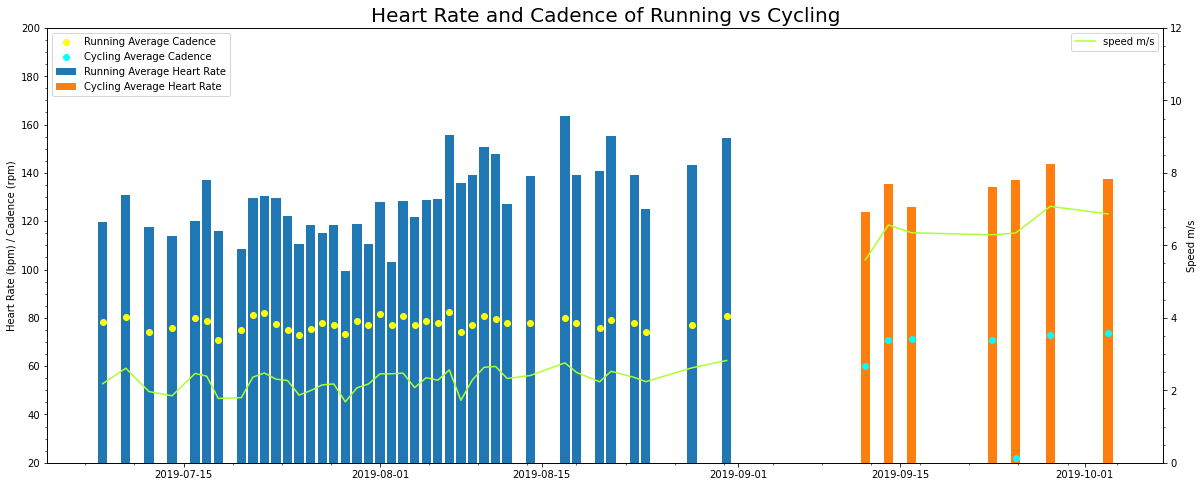

In [5]:
# Group by the dataframe by datafile column
df_workout = dfc.groupby(dfc['datafile']).mean()

len(df_workout) # = 64 #print the len of the df. 

def activity(x):
    if x >= 5:
        return 'cycling'
    if x < 5 :
        return 'running'

df_workout['activity'] = df_workout['enhanced_speed'].apply(activity)

df_workout = df_workout.reset_index()[['datafile','activity']]

df_a = pd.merge(dfc,df_workout, on = 'datafile')
df_a = df_a[['timestamp','enhanced_speed','Cadence','date','heart_rate','activity']].dropna()

df_running = df_a[df_a.activity == 'running']
df_running = df_running.groupby(df_running['date']).mean()
df_cycling = df_a[df_a.activity == 'cycling']
df_cycling = df_cycling.groupby(df_cycling['date']).mean()
df_cycling



fig,ax1 = plt.subplots(figsize=(20, 8))
ax1.bar(df_running.index.to_timestamp(),df_running.heart_rate,label='Running Average Heart Rate')
ax1.bar(df_cycling.index.to_timestamp(),df_cycling.heart_rate,label='Cycling Average Heart Rate')
ax1.scatter(df_running.index.to_timestamp(),df_running.Cadence,label='Running Average Cadence',color='yellow')
ax1.scatter(df_cycling.index.to_timestamp(),df_cycling.Cadence,label='Cycling Average Cadence',color='aqua')
ax1.minorticks_on()
ax1.legend(loc='upper left')
ax1.set_ylabel('Heart Rate (bpm) / Cadence (rpm)')
ax1.set_title('Heart Rate and Cadence of Running vs Cycling',size = 20)
ax1.set_ylim([20,200])

ax2 = ax1.twinx()
ax2.set_ylim([0,12])
ax2.plot(df_running.index.to_timestamp(), df_running.enhanced_speed, label = 'speed m/s',color = 'greenyellow')
ax2.plot(df_cycling.index.to_timestamp(), df_cycling.enhanced_speed, label = '_nolegend_',color = 'greenyellow')
ax2.set_ylabel('Speed m/s')
ax2.legend(loc='upper right')
ax2.minorticks_on()
plt.show()


#### Insights:

For the green line in the above chart, we can clearly see that in July and August of 2019, The user was mostly running during workouts. Average speed was like 3m/s. He took some breaks between 09/01/2019 to 09/10/2019, and then restarted workouts in cycling, with an average speed of around 7m/s. 

In terms of heart rate, I don't see a huge difference between running and cycling. But I can see some positive correlation between speed and heart rate in the same activity. Higher speed in running means higher heart rate while running, and cycling data has the same trend as well.

In running, cadence is often defined as the total number of steps taking per minute. It is generally agreed that somewhere around 90 rpm (180 spm) is the sweet spot for running efficiency and economy(McCusker, 2019). Cadence in running can be measured as revolutions per minute (RPM), which is steps per minute (spm)divided by 2. 

Cadence in cycling is defined as the number of revolutions per minute (RPM). 85 - 90 rpm is considered a high cadence for cycling.

The user has a rpm of running close to 80, and his cadence for cycling is a bit lower than running at around 70. There is an outlier on 09/25/2019 where the cadence was only 20 but the speed was normal at 6+m/s. Maybe the device wasn't catching the data correctly for that day. Or maybe he was doing something else other than running/cycling on that day? Like riding a horse?

### 3. Line Chart with a Trend Line for Daily Distance
#### Q. How far does the user usually go(walking/cycling/running,etc.) each day? Is he progressing?
Looking at the distance column of last 5 row of the data, at first glance I thought The user was moving 38kms per second - which is impossible! I realized that it's a cumulative number. so I created a new column for the distance per observation window. And then I created a new dataframe grouping by date to get distance per day.

In [6]:
dfc.iloc[-5:]

,Air Power,Form Power,Ground Time,Leg Spring Stiffness,Power,Vertical Oscillation,enhanced_altitude,datafile,distance,heart_rate,position_lat,position_long,enhanced_speed,timestamp,Cadence,lat,lng,date
40644,NaN,NaN,NaN,NaN,NaN,NaN,273.6,activities/2925939753.fit.gz,38627.30,143.0,504554553.0,-999308618.0,5.981,2019-10-03 23:04:54,62.0,50.455455,-99.930862,2019-10-03
40645,NaN,NaN,NaN,NaN,NaN,NaN,273.6,activities/2925939753.fit.gz,38635.65,142.0,504553919.0,-999309466.0,4.115,2019-10-03 23:04:56,62.0,50.455392,-99.930947,2019-10-03
40646,NaN,NaN,NaN,NaN,NaN,NaN,274.0,activities/2925939753.fit.gz,38638.63,142.0,504553588.0,-999309432.0,3.322,2019-10-03 23:04:57,62.0,50.455359,-99.930943,2019-10-03
40647,NaN,NaN,NaN,NaN,NaN,NaN,277.4,activities/2925939753.fit.gz,38649.99,138.0,504552459.0,-999308808.0,1.680,2019-10-03 23:05:02,23.0,50.455246,-99.930881,2019-10-03
40648,NaN,NaN,NaN,NaN,NaN,NaN,277.8,activities/2925939753.fit.gz,38652.59,135.0,504552222.0,-999308613.0,0.961,2019-10-03 23:05:05,22.0,50.455222,-99.930861,2019-10-03


In [7]:
df_d = dfc[['date','timestamp','distance']] 
df_d['daily_dist'] = df_d['distance'].diff()
df_d['daily_dist'] = df_d['daily_dist'].apply(lambda x: 0 if x < 0 else x/1000) #reset to 0 for new datafile and change scale to kilometers from meters

df_daily_group = df_d.groupby([df_d['timestamp'].values.astype('datetime64[D]')]).sum()
series = df_daily_group['daily_dist']
series.head()

2019-07-08     2.61746
2019-07-10     2.53032
2019-07-12     7.47184
2019-07-14    11.08360
2019-07-16     2.41601
Name: daily_dist, dtype: float64

#### And then I created a line chart with a trend line

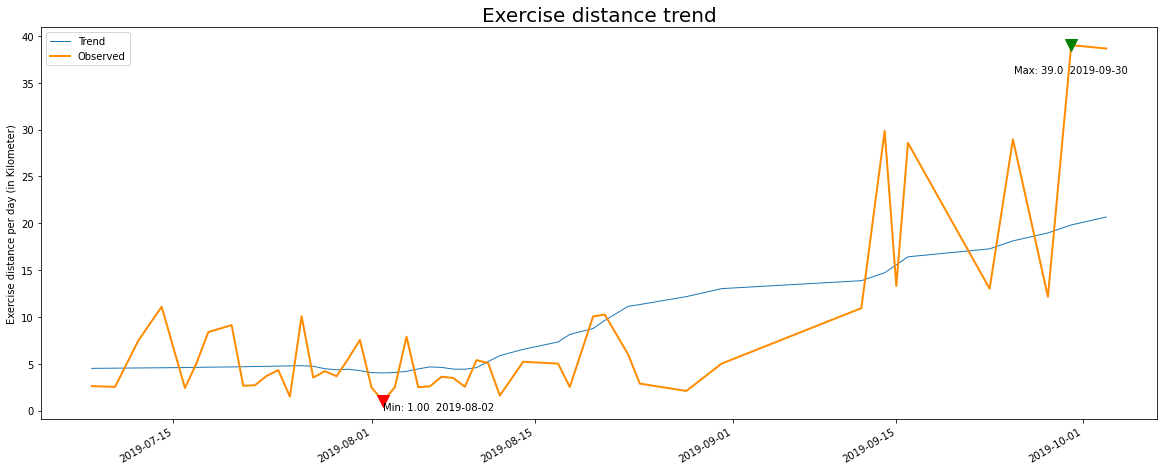

In [8]:
decomposed = sm.tsa.seasonal_decompose(series, extrapolate_trend=1, period=24)

# Create plot
fig = plt.figure(figsize=(20, 8))

# Plot and customize
ax = decomposed.trend.plot(label='Trend', linewidth=1)
# ax = decomposed.observed.plot(label='Observed', linewidth=2.0)

ax.plot(series,color = 'darkorange',label='Observed',linewidth=2.0)

ax.legend()
ax.set_title('Exercise distance trend',size = 20)
ax.set_ylabel('Exercise distance per day (in Kilometer)')

high = df_daily_group['daily_dist'].max()
low = df_daily_group['daily_dist'].min()
ax.plot(series.idxmax(),high,marker="v", linestyle="", alpha= 1, color="g",markersize=12)
ax.plot(series.idxmin(),low, marker="v", linestyle="", alpha= 1, color="r",markersize=12)
ax.annotate('Max: ' + str(high)[:4] + '  ' + str(series.idxmax())[:10],  xy=(series.idxmax(),high),xytext=(series.idxmax(),high-3),horizontalalignment='center')
ax.annotate('Min: ' + str(low)[:4] + '  ' + str(series.idxmin())[:10],  xy=(series.idxmin(),low),xytext=(series.idxmin(),low-1))

plt.show()



#### Insights:

The above chart features a line chart to visualize the distance that The user goes on each day. The longest distance was 39km on 2019/09/30 and the shortest distance was 1km on 2019/08/02. 

I also created the trend line using STL(Seasonal-Trend decomposition using LOESS) on the same plot. 

So now we can answer the question: The user was progressing on his exercise distance during Jul - Oct 2019! 

And it aligns with my assumptions above that he was running in July and August, and then switched to cycling from 09/10/2019 so he was able to go much further.



## Advanced Visualization Technique

### A geo map showing route of cycling and color coded with speed using Folium


#### Q. Where does the user usually go? What is his cycling route like? 

#### First of all, let's find out where did the the user start
Here I wanted to introduce a new visualization libraby: folium.
You may install folium using `!pip install folium`

I selected the first non-null value for latitude and longtitude and found out that he was in an area called reserve (Rolling River 67), to the south of the Riding Mountain National Park, Canada.

In [9]:
#select the first non-null value for latitude and longtitude. 
dfg = dfc[['timestamp','lat', 'lng','enhanced_speed','enhanced_altitude']]
lat1 = dfg.lat[3] #first non-null value
lng1 = dfg.lng[3] #first non-null value
dfg = dfg[['timestamp','lat', 'lng','enhanced_speed','enhanced_altitude']].dropna()
df_hourly = dfg.groupby([pd.Grouper(key='timestamp', freq='1H')]).mean().dropna()
df_hourly = df_hourly.reset_index()


### 1. Starting Point 

In [10]:
m = folium.Map(location=[lat1, lng1],zoomstart = 13,width=1024,height=600)
tooltip = "Here is where The user was exercising!"
folium.Marker(location = [lat1, lng1], popup = 'Starting Point', icon = folium.Icon(icon = 'glyphicon glyphicon-user',color='orange'), tooltip = tooltip).add_to(m)
m

#### Above is where The user started his exercise on the first day in his dataset!

### 2. Main Exercise Area Each Day

Let's take a look at where he usually goes each day

In [11]:
for i, row in df_hourly.iterrows():
    lat = df_hourly.at[i, 'lat']
    lng = df_hourly.at[i, 'lng']
    
    popup = ' Datetime: ' + str(df_hourly.at[i, 'timestamp']) + ' Altitude: ' + str(df_hourly.at[i, 'enhanced_altitude'])[:3] +'m' + ' Average Speed : ' + str(df_hourly.at[i, 'enhanced_speed'])[:4] + 'm/s'
    folium.Marker(location = [lat, lng], popup = popup, icon = folium.Icon(icon='bicycle', prefix='fa',color='blue')).add_to(m)
m

#### The above map shows where the the user went for exercise each day. It looks like he likes to go to the same area almost everyday,except for 08/17/2019 he went to a place near Shoal Lake. 

### 3. Route Of The Longest Distance In One Day

#### From the 'df_daily_group' dataframe created above, we can tell that the max daily distance that the user exercised was 39km, on 09/30/2019. It would be interesting to see his route on that day.

In [12]:
df_daily_group[df_daily_group.daily_dist == df_daily_group.daily_dist.max()]

,distance,daily_dist
2019-09-30,22990659.83,39.00712


In [13]:
df_route = dfc[dfc['date']=='2019-09-30']
df_route = df_route.resample('1Min',on='timestamp').mean()
df_route = df_route.reset_index()
df_route.head()

,timestamp,Air Power,Form Power,Ground Time,Leg Spring Stiffness,Power,Vertical Oscillation,enhanced_altitude,distance,heart_rate,position_lat,position_long,enhanced_speed,Cadence,lat,lng
0,2019-09-30 21:25:00,NaN,NaN,NaN,NaN,NaN,NaN,291.685714,15.678571,NaN,5.044236e+08,-9.990667e+08,1.025000,70.000000,50.442358,-99.906671
1,2019-09-30 21:26:00,NaN,NaN,NaN,NaN,NaN,NaN,306.155556,74.365556,NaN,5.044278e+08,-9.990680e+08,1.326889,33.400000,50.442776,-99.906803
2,2019-09-30 21:27:00,NaN,NaN,NaN,NaN,NaN,NaN,283.973333,149.624000,NaN,5.044330e+08,-9.990724e+08,3.754667,52.333333,50.443302,-99.907241
3,2019-09-30 21:28:00,NaN,NaN,NaN,NaN,NaN,NaN,281.157143,396.906429,NaN,5.044356e+08,-9.991067e+08,4.304714,56.454545,50.443556,-99.910669
4,2019-09-30 21:29:00,NaN,NaN,NaN,NaN,NaN,NaN,275.636364,625.568636,NaN,5.044433e+08,-9.991318e+08,3.554636,53.812500,50.444332,-99.913176


#### I firstly created a basic scatter chart of matplotlib as below, but it's not as informational and beautiful as I want. 

Text(0.5, 1.0, 'Route latitude and longitude points')

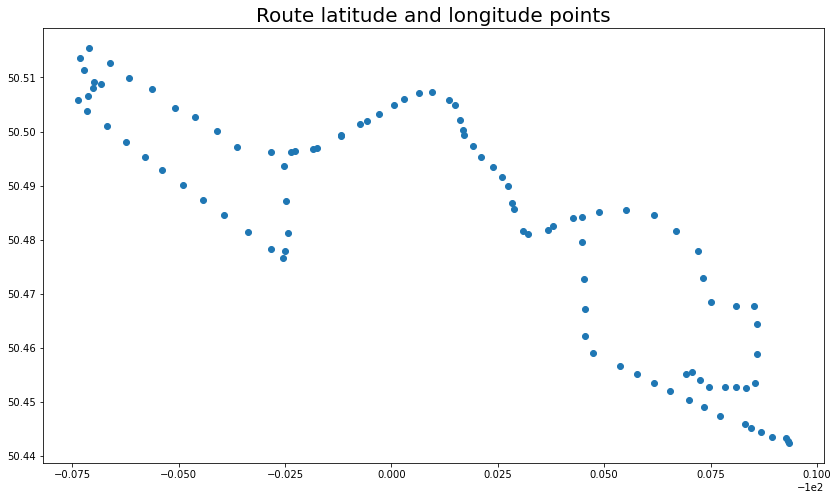

In [14]:
plt.figure(figsize=(14, 8))
plt.scatter(df_route['lng'], df_route['lat'])
plt.title('Route latitude and longitude points', size=20)

#### Let's see how folium can help us improve

In [15]:
Routemap = folium.Map(location=[lat1, lng1],zoomstart = 13,width=1024,height=600)

for i, row in df_route.iterrows():
    lat = df_route.at[i, 'lat']
    lng = df_route.at[i, 'lng']

    folium.Circle(
        location = [lat, lng], 
        color = 'orange',
        radius = 40,
        popup = str(df_route.at[i,'timestamp']) + '   Speed:'+ str(df_route.at[i,'enhanced_speed'])[:3] + 'm/s', 
        tooltip='Zoom in and Click here for time'
    ).add_to(Routemap)
    
coordinates = [tuple(x) for x in df_route[['lat', 'lng']].to_numpy()]

import branca
colormap = branca.colormap.LinearColormap(colors = ['green', 'yellow', 'red'], vmax=13)
colormap.scale(vmax=13)
colormap = colormap.to_step(6).to_linear()
colormap.caption = 'Speed'
colormap.add_to(Routemap)

folium.ColorLine(
        positions = coordinates, # tuple of coordinates 
        weight = 6,
        colors = df_route.enhanced_speed.astype(int), # map each segment with the speed 
        colormap = colormap, # map each value with a color 
        ).add_to(Routemap)

folium.Marker(
      location=[df_route.at[0,'lat'], df_route.at[0,'lng']],
      popup= 'Starting Point' +' ' +  str(df_route.at[0,'timestamp']),
      icon = folium.Icon(icon='bicycle',prefix='fa',color='lightblue')
   ).add_to(Routemap)


folium.Marker(
      location=[df_route.at[99,'lat'], df_route.at[99,'lng']],
      popup= 'Ending Point' +' ' +  str(df_route.at[99,'timestamp']),
      icon = folium.Icon(icon='glyphicon glyphicon-flag',color='blue')
   ).add_to(Routemap)

display(Routemap)



#### Amazing! So simple and elegant! Please play around with the interative feature in the map above and see what you can get from it.

#### Insights: 
Story behind: on 09/30/2019, the user decided to bike around the waterlands of rolling river 67 reserve. He started slowly at around 21:25pm, and increased speed later to a moderate level at 8 to 9 m/s, and biked really fast at a few points at 11 m/s.He finished his workout around 11pm. 

Zooming into the route, I created some circle marks on his route, by clicking it you will be able to see the timestamp and speed at that location. 
I also created a legend using an extra library called 'branca', and encoded the speed with color into the route map. 



## Summary

The above visualizations explored the fitness dataset from an user of strava which contains his workout data between July and October 2019. I used four of the basic visual analysis techniques in this class including scatter, line, bar and histograms to visualize the columns in the strava dataset. Firstly I created an overview of the dataset using histograms, and then I dived in and analyzed the heart rate and cadence for different activities. In addition, I analyzed the distance column in the data and visualized the trend of distance of the workouts. 

From the visualizations, we can see that the activities included running and biking. The user liked to go to rolling river 67 water reserve in  Manitoba, Canada, where the land was mostly flat and good for leisure running and cycling. The user didn't seem to be doing a lot of intense workouts, but overall he was doing great and gradually increasing the distance and length of the workouts. We can tell that he was progressing from the graphs. 

To further analyze the data, I learnt a new library called 'Folium' to visualize the route of workouts using the coordinates provided in the dataset. It's a real map and it's interactive, offering the function of zooming in and out. I was able to encode color for the speed on the route map showing how fast the the user was cycling, and was able to mark the starting and ending points using different icons. 

It's a great dataset to learn to clean up messy reallife data and explore fitness metrics using matplotlib and Folium. Through exploration of the data, I was able to imagine the whole story behind the data and found analytics on fitness data is actually interesting. There are so much to dive into, visualize and present. There are other analysis we can do using the data, for example, creating heatmaps to show correlation between speed and heartrate or cadence. Due to the limit of time, I am not able to cover all the analysis I would like to do here, but there is no doubt that we can create many other exciting visualizations based on this dataset. 

I enjoyed this exercise and hope you do as well!











## References:

Radečić, D. (2022, January 4). Data Science For Cycling — How to Visualize GPX Strava Routes With Python and Folium. Medium. https://towardsdatascience.com/data-science-for-cycling-how-to-visualize-gpx-strava-routes-with-python-and-folium-21b96ade73c7

Johannes J. (2019, March 13). Analyze your cycling data with Python. http://johannesjacob.com/2019/03/13/analyze-your-cycling-data-python/

Namburu, V. (2021, December 15). Exploratory Data Analysis of Google Fit data with Pandas and Seaborn. Medium. https://medium.com/analytics-vidhya/exploratory-data-analysis-of-google-fit-data-with-pandas-and-seaborn-a4369366c543

Kang, C. (2020, August 22). Analyze Your Runkeeper Fitness Data. https://goodboychan.github.io/python/datacamp/data_science/time_series_analysis/2020/08/22/01-Analyze-Your-Runkeeper-Fitness-Data.html

McCusker, C. (2019). Tracking Cadence, Heart Rate, and Pace While Running. Suunto. https://www.suunto.com/en-us/sports/News-Articles-container-page/tracking-cadence-heart-rate-and-pace-while-running/#:%7E:text=While%20there%20are%20many%20different,for%20running%20efficiency%20and%20economy

Exercise intensity: How to measure it. (2021, June 17). Mayo Clinic. https://www.mayoclinic.org/healthy-lifestyle/fitness/in-depth/exercise-intensity/art-20046887?reDate=29032022#:%7E:text=You%20can%20calculate%20your%20maximum,beat%20per%20minute%20during%20exercise.

Green, M. (2022, February 14). Cycling Cadence - What is it and how do you improve it. The Body Mechanic. https://thebodymechanic.com.au/cycling-cadence-what-is-it-and-why-you-should-keep-a-close-eye-on-yours/#:%7E:text=Recreational%20cyclists%20typically%20cycle%20at,on%20your%20legs%20and%20back.

Garmin. (2022). Explanation of the Ground Contact Time Feature on a Garmin Watch | Garmin Customer Support. Garmin.Com. https://support.garmin.com/en-US/?faq=dBYMCeqH0o9LYIm6Rm4c89#:%7E:text=Ground%20contact%20time%20(GCT)%20is,especially%20short%20for%20elite%20runners.